# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK** 

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi studi kasus dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Mendownload Dataset dari Github

In [2]:
# Mendownload datasheet dari github dan mengekstrak file
!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
!unzip -P paddy paddy.zip


--2019-11-19 00:31:03--  https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617909 (3.5M) [application/zip]
Saving to: ‘paddy.zip’

paddy.zip           100%[===================>]   3.45M  --.-KB/s    in 0.1s    

2019-11-19 00:31:04 (33.8 MB/s) - ‘paddy.zip’ saved [3617909/3617909]

--2019-11-19 00:31:04--  http://paddy.zip/
Resolving paddy.zip (paddy.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘paddy.zip’
FINISHED --2019-11-19 00:31:04--
Total wall clock time: 1.2s
Downloaded: 1 files, 3.5M in 0.1s (33.8 MB/s)
Archive:  paddy.zip
   creating: paddy/
  inflating: paddy/bamboopaddy_forest_detection.ipynb  
   creating: paddy/chopped/
   creating: paddy/test/
  inflat

**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [3]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls paddy/train
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

b10.jpg  b13.jpg  b2.jpg  b5.jpg  b8.jpg   o1.jpg  o4.jpg  o7.jpg
b11.jpg  b14.jpg  b3.jpg  b6.jpg  b9.jpg   o2.jpg  o5.jpg  o8.jpg
b12.jpg  b1.jpg   b4.jpg  b7.jpg  o10.jpg  o3.jpg  o6.jpg  o9.jpg


#Menginput/Memasukan Gambar Pelatihan dan Menampilkannya

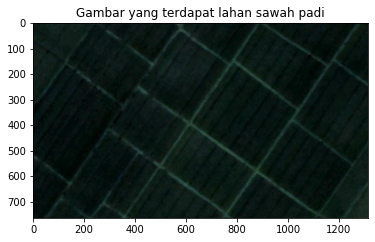

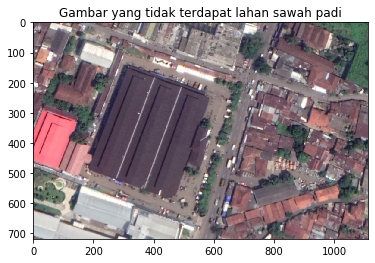

In [4]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("paddy/train/b2.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("paddy/train/o10.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [5]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)

##Mengembalikan daftar gambar train pada direktori
files = os.listdir("paddy/train/")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "paddy/chopped"
    file = os.path.join("paddy/train/",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00000.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00001.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00002.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00003.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00004.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b5_00005.jpg is a low contrast image
  warn('%s is a low

In [6]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
files = os.listdir("paddy/chopped/")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("paddy/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(12983, 56, 56, 3) (12983,)


In [7]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.9,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(1298, 56, 56, 3)
(1298,)
(11685, 56, 56, 3)
(11685,)


In [8]:
#Mengkomputasi kelas bobotnya
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([691, 607]))
(array([0, 1]), array([6218, 5467]))
[0.93921852 1.06919275]


# Membuat Pemodelan dan Pelatihan Model

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

#Pembuatan Model

In [9]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        9248      
____________________

#Pelatihan


In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(train_x,train_y,batch_size=50,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])




Train on 1298 samples, validate on 11685 samples
Epoch 1/100





1298/1298 [==============================] - 9s 7ms/step - loss: 0.4700 - acc: 0.7242 - val_loss: 0.3251 - val_acc: 0.9289

Epoch 00001: val_loss improved from inf to 0.32512, saving model to paddy.h5
Epoch 2/100
1298/1298 [==============================] - 1s 833us/step - loss: 0.1412 - acc: 0.9761 - val_loss: 0.0299 - val_acc: 0.9926

Epoch 00002: val_loss improved from 0.32512 to 0.02986, saving model to paddy.h5
Epoch 3/100
1298/1298 [==============================] - 1s 798us/step - loss: 0.0305 - acc: 0.9908 - val_loss: 0.0157 - val_acc: 0.9957

Epoch 00003: val_loss improved from 0.02986 to 0.01570, saving model to paddy.h5
Epoch 4/100
1298/1298 [==============================] - 1s 796us/step - loss: 0.0376 - acc: 0.9861 - val_loss: 0.1325 - val_acc: 0.9569

Epoch 00004: val_loss did not improve from 0.01570
Epoch 5/100
1298/1298 [==============================] - 1s 837us/step - loss: 0.0352 - acc: 0.9900 - v

#Menggambarkan Hasil Pelatihan

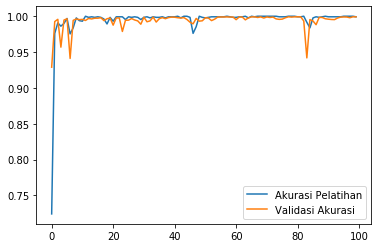

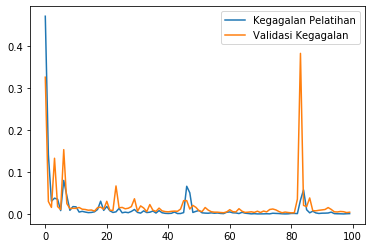

In [11]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi Gambar Pelatihan dengan Gambar Test data

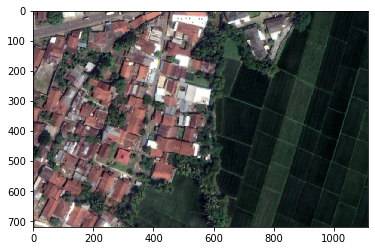

30
1410 30 47


In [12]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "paddy/test/test_image.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)


#Prediksi Gambar Individual

(1410, 1)
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.9931365 ]
 [0.9940164 ]
 [0.99999714]]


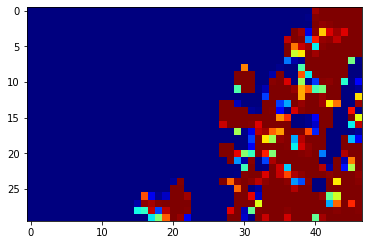

In [13]:
#Memprediksi prpbalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [14]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(690, 1081)


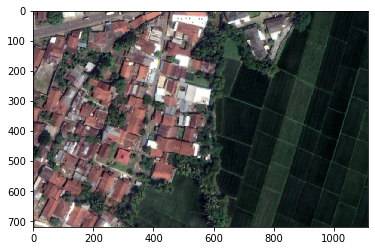

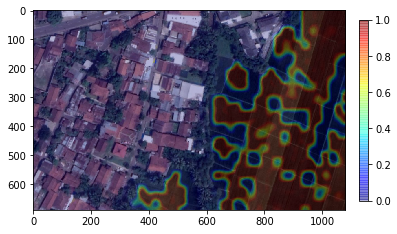

In [15]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


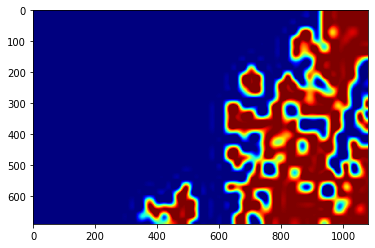

In [16]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [17]:
(zoomed>1).sum()

669876

In [18]:
np.amax(zoomed)

1.3290968

In [19]:
np.amin(zoomed)

-0.45660314